In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from comet_ml import Experiment

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

hotels = pd.read_csv('data/hotels.csv')

In [2]:
# All experiments will be traced with CometML

experiment = Experiment(
     api_key='2ZlKWCvoe3rTUNPPPRpjc8C19',
     project_name='booking-com-hotels-ratings',
     workspace='nataliamantyk')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/nataliakonovalova/Documents/SKILLFACTORY/PROJECT - 3_EDA & Feature Engineering' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/nataliamantyk/booking-com-hotels-ratings/b9f05268a0034f5aa32e5d07d23df466



In [3]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

# Exploratory Data Analysis
## Creating new features
### 1. Date of review

In [4]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['season'] = hotels['review_date'].dt.month

def get_season(arg):
    if arg in list(range(3,6)):
        return 'spring'
    if arg in list(range(6,9)):
        return 'summer'
    if arg in list(range(9,12)):
        return 'autumn'
    else:
        return 'winter'

hotels['season'] = hotels['season'].apply(get_season)

### 2. Nationality of Reviewer

In [5]:
# Delete the space at the begining of text
import re

def space(row):
    country = re.sub(r'^\s+|\s+$', '', row)
    if len(country) > 0:
        return country
    else:
        return None
    
hotels['reviewer_country'] = hotels['reviewer_nationality'].apply(space)


# Convert nationality into continent
import pycountry_convert as pc

def convert(row):
    try:
        cn_code = pc.country_name_to_country_alpha2(row.reviewer_country, cn_name_format = 'default')
    except:
        cn_code = None
    try:
        conti_code = pc.country_alpha2_to_continent_code(cn_code)
    except:
        conti_code = None
    return conti_code

hotels['reviewer_continent'] = hotels.apply(convert, axis = 1)



# Filling the gaps
value = {'reviewer_country':hotels['reviewer_country'].mode()[0],
        'reviewer_continent':hotels['reviewer_continent'].mode()[0]}

hotels = hotels.fillna(value)

### 3. Positive & Negative Review Analisys

In [6]:
import nltk

#Download the lexicon
nltk.download('vader_lexicon')

#Import the lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

#Create an instance of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer() 



# Replacing controversial words
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('Nothing', 'Positive'))

hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('Nothing', 'Negative'))



# Functions to assign specific descriptions of emotions
def format_output(output_dict):
    polarity = 'neutral'
    
    if (output_dict['compound'] >= 0.05):
        polarity = 'positive'
    
    elif (output_dict['compound'] <= 0.05):
        polarity = 'negative'
    
    return polarity

def predict_sentiment(row):
    
    output_dict = sia.polarity_scores(row)
    
    return format_output(output_dict)

hotels['negative_vader'] = hotels['negative_review'].apply(predict_sentiment)
hotels['positive_vader'] = hotels['positive_review'].apply(predict_sentiment)




# Scoring of each emotion type and compound
hotels['negative_review_score'] = hotels['negative_review'].apply(
    lambda x: sia.polarity_scores(x))

hotels['positive_review_score'] = hotels['positive_review'].apply(
    lambda x: sia.polarity_scores(x))

hotels['neg_negative_review_score'] = hotels['negative_review_score'].apply(
    lambda x: x['neg'])
hotels['neu_negative_review_score'] = hotels['negative_review_score'].apply(
    lambda x: x['neu'])
hotels['pos_negative_review_score'] = hotels['negative_review_score'].apply(
    lambda x: x['pos'])
hotels['com_negative_review_score'] = hotels['negative_review_score'].apply(
    lambda x: x['compound'])



hotels['neg_positive_review_score'] = hotels['positive_review_score'].apply(lambda x: x['neg'])
hotels['neu_positive_review_score'] = hotels['positive_review_score'].apply(lambda x: x['neu'])
hotels['pos_positive_review_score'] = hotels['positive_review_score'].apply(lambda x: x['pos'])
hotels['com_positive_review_score'] = hotels['positive_review_score'].apply(lambda x: x['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nataliakonovalova/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 4. Extracting Information from Tags

In [7]:
# Type of the reviewer trip
def get_trip_type(arg):
    arg = ' '.join(arg.split(' ')[:3])
    if 'Business trip' in arg:
        return 'Business'
    if 'Leisure trip' in arg:
        return 'Leisure'
    else:
        return None

hotels['trip_type'] = hotels['tags'].apply(get_trip_type)


# Number of travellers during each stay
def get_people(arg):
    if 'Solo traveler'in arg:
        return 'Solo'
    if 'Family with' in arg:
        return 'Family'
    if 'Couple' in arg:
        return 'Couple'
    if 'Group' in arg:
        return 'Group'
    else:
        return None
    
hotels['traveler'] = hotels['tags'].apply(get_people)

# Number of nights
hotels['nights'] = hotels['tags'].str.findall(r'Stayed\s\d+')

def list_to_string(arg):
    str_1 = ' '
    return(str_1.join(arg))

hotels['nights'] = hotels['nights'].apply(list_to_string)

def get_number(arg):
    number = re.findall(r'\d+', arg)
    if len(number)>0:
        return number[0]
    else:
        return None

hotels['nights'] = hotels['nights'].apply(get_number)


# Filling the gaps
value_1 = {'trip_type':hotels['trip_type'].mode()[0],
        'traveler':hotels['traveler'].mode()[0],
        'nights':hotels['nights'].mode()[0]}

hotels = hotels.fillna(value_1)

### 5. Extracting Information from Hotel Address
#### 5.1. Country and City for each Hotel

In [8]:
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

hotels['hotel_city'] = hotels['hotel_address'].apply(
    lambda x: 'London' if 'London' in x else x.split()[-2])

#### 5.2. Filling Lat & Lng

In [9]:
# 1. Analysis of gaps by each city
lat_lng_null = hotels[hotels.isnull().any(1)]['hotel_city'].value_counts()

# 2. Using postal codes as indicators and mode values for lat & lng
def get_postal_code(arg):
    city = ['Vienna', 'Paris', 'Barcelona', 'Milan']
    arg_splitted = arg.split()
    if arg_splitted[-2] in city:
        return arg_splitted[-3]
    
    elif arg_splitted[-1] == 'Kingdom':
        return ' '.join(arg_splitted[-4:-2])
    
    elif arg_splitted[-1] == 'Netherlands':
        return ' '.join(arg_splitted[-4:-2])
    
    else:
        return arg
    
hotels['postal_code'] = hotels['hotel_address'].apply(get_postal_code)


vienna_lat_post = hotels[(hotels['postal_code'] == '1010')]['lat'].mode()[0]
vienna_lng_post = hotels[(hotels['postal_code'] == '1010')]['lng'].mode()[0]

paris_lat_post = hotels[(hotels['postal_code'] == '75008')]['lat'].mode()[0]
paris_lng_post = hotels[(hotels['postal_code'] == '75008')]['lng'].mode()[0]

barcelona_lat_post = hotels[(hotels['postal_code'] == '08002')]['lat'].mode()[0]
barcelona_lng_post = hotels[(hotels['postal_code'] == '08002')]['lng'].mode()[0]


mode_post = {'Vienna': [vienna_lat_post, vienna_lng_post],
          'Paris': [paris_lat_post, paris_lng_post],
          'Barcelona': [barcelona_lat_post, barcelona_lng_post]}

hotels['lat'] = hotels.apply(
    lambda row: mode_post[row.hotel_city][0] \
    if pd.isna(row.lat) else row['lat'], axis=1)



hotels['lng'] = hotels.apply(
    lambda row: mode_post[row.hotel_city][1] \
    if pd.isna(row.lng) else row['lng'], axis=1)

### 6. Name of Hotels Review

In [10]:
# Including not popular hotels into group "other": total number of reviews less than 100
hotels_names = hotels.groupby('hotel_name')['total_number_of_reviews'].agg(['count'])

mask = (hotels_names['count'] >= 100)
popularity = hotels_names[mask]

hotels['hotel_popularity'] = hotels['hotel_name'].apply(lambda x: x if x in popularity.index else 'other')

In [11]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

# Encoding Categorical columns

In [12]:
import category_encoders as ce

#Ordinal Encoding
ord_enc = ce.OrdinalEncoder()
hotels[['negative_vader', 'positive_vader', 'trip_type']] = ord_enc.fit_transform(
    hotels[['negative_vader', 'positive_vader', 'trip_type']])


# OneHotEncoding
ohe_columns = ['hotel_country', 'hotel_city', 'season', 'reviewer_continent', 'traveler']
hotels = pd.get_dummies(hotels, columns = ohe_columns)


# Binary Encoding
bin_encoder = ce.BinaryEncoder(cols = ['hotel_popularity', 'postal_code', 'reviewer_country', 'nights'])

hotels_bin = bin_encoder.fit_transform(hotels[['hotel_popularity', 'postal_code', 'reviewer_country', 'nights']])

hotels = pd.concat([hotels, hotels_bin], axis = 1)

# Correlation

In [13]:
# Continuous features

num_cols = ['additional_number_of_scoring',
            'average_score',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'neg_negative_review_score',
            'neu_negative_review_score',
            'pos_negative_review_score',
            'com_negative_review_score',
            'neg_positive_review_score',
            'neu_positive_review_score',
            'pos_positive_review_score',
            'com_positive_review_score',
           
           'nights_0', 'nights_1', 'nights_2', 'nights_3', 'nights_4']

# Categorical features
cat_cols = ['season_autumn', 'season_spring', 'season_summer', 'season_winter',
            
           'reviewer_country_0', 'reviewer_country_1', 'reviewer_country_2', 'reviewer_country_3', 'reviewer_country_4',
           'reviewer_country_5', 'reviewer_country_6', 'reviewer_country_7',
           
           'reviewer_continent_AF', 'reviewer_continent_AS', 'reviewer_continent_EU', 'reviewer_continent_NA',
           'reviewer_continent_OC', 'reviewer_continent_SA',
           
           'negative_vader', 'positive_vader', 'trip_type',
           
           'traveler_Couple', 'traveler_Family', 'traveler_Group', 'traveler_Solo',
           
           'hotel_country_Austria', 'hotel_country_France', 'hotel_country_Italy', 'hotel_country_Netherlands',
           'hotel_country_Spain', 'hotel_country_United Kingdom',
           
           'hotel_city_Amsterdam', 'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Milan', 'hotel_city_Paris',
           'hotel_city_Vienna',
           
           'postal_code_0', 'postal_code_1', 'postal_code_2', 'postal_code_3', 'postal_code_4', 'postal_code_5',
           'postal_code_6', 'postal_code_7', 'postal_code_8', 'postal_code_9',
           
           'hotel_popularity_0', 'hotel_popularity_1', 'hotel_popularity_2', 'hotel_popularity_3', 'hotel_popularity_4',
           'hotel_popularity_5', 'hotel_popularity_6', 'hotel_popularity_7', 'hotel_popularity_8', 'hotel_popularity_9']


{'web': 'https://www.comet.com/api/image/download?imageId=d5885f8616da44fe809579204e55a105&experimentKey=b9f05268a0034f5aa32e5d07d23df466',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=d5885f8616da44fe809579204e55a105&experimentKey=b9f05268a0034f5aa32e5d07d23df466',
 'imageId': 'd5885f8616da44fe809579204e55a105'}

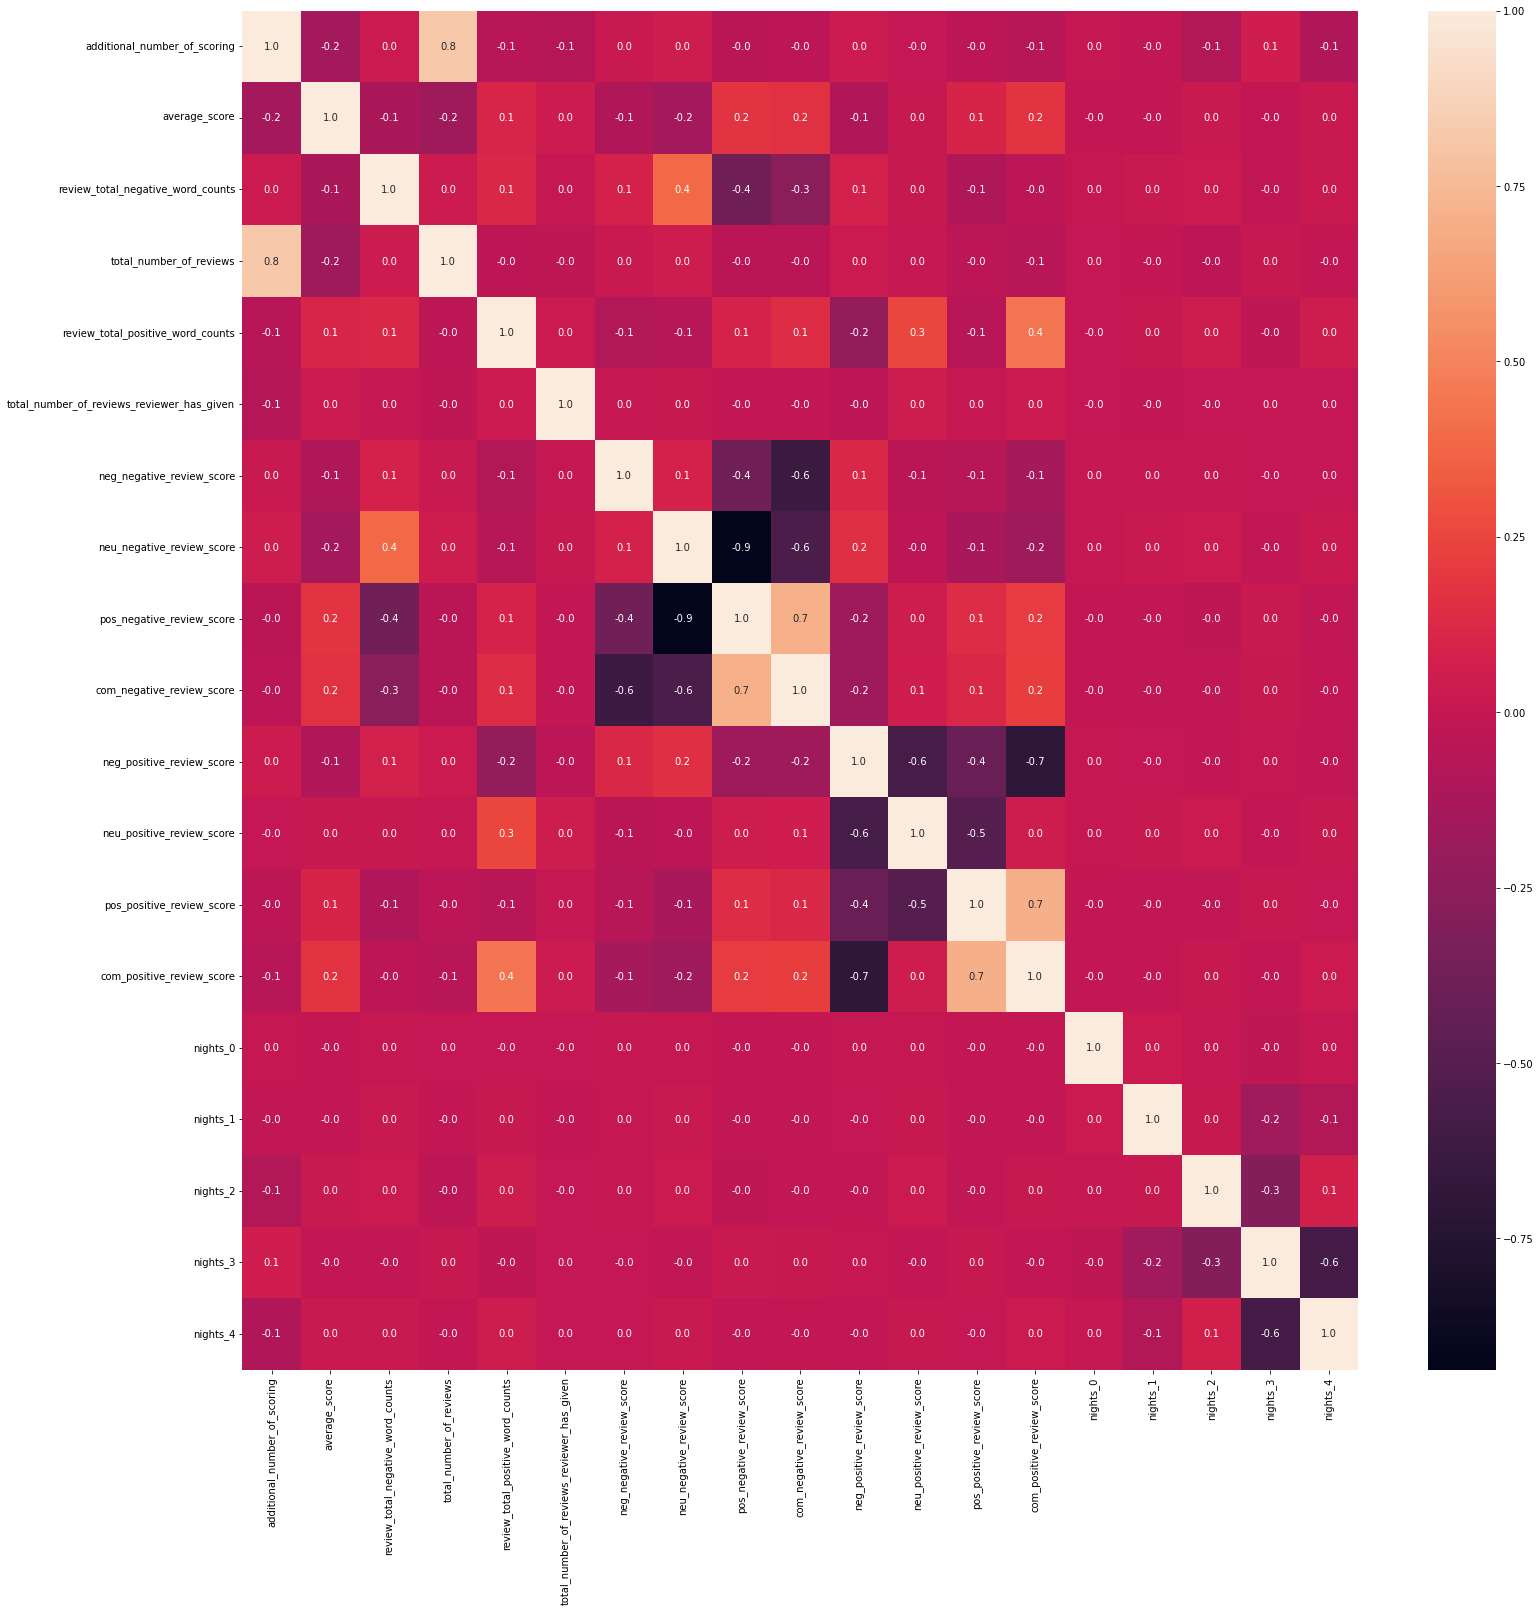

In [14]:
# Correlation Pearson for numerical data

fig = plt.figure(figsize=(25, 25))
sns.heatmap(hotels[num_cols].corr(), annot = True, fmt=".1f");

experiment.log_figure(figure = plt)

{'web': 'https://www.comet.com/api/image/download?imageId=fab748cf4b38440191b6bd3bd534543f&experimentKey=b9f05268a0034f5aa32e5d07d23df466',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=fab748cf4b38440191b6bd3bd534543f&experimentKey=b9f05268a0034f5aa32e5d07d23df466',
 'imageId': 'fab748cf4b38440191b6bd3bd534543f'}

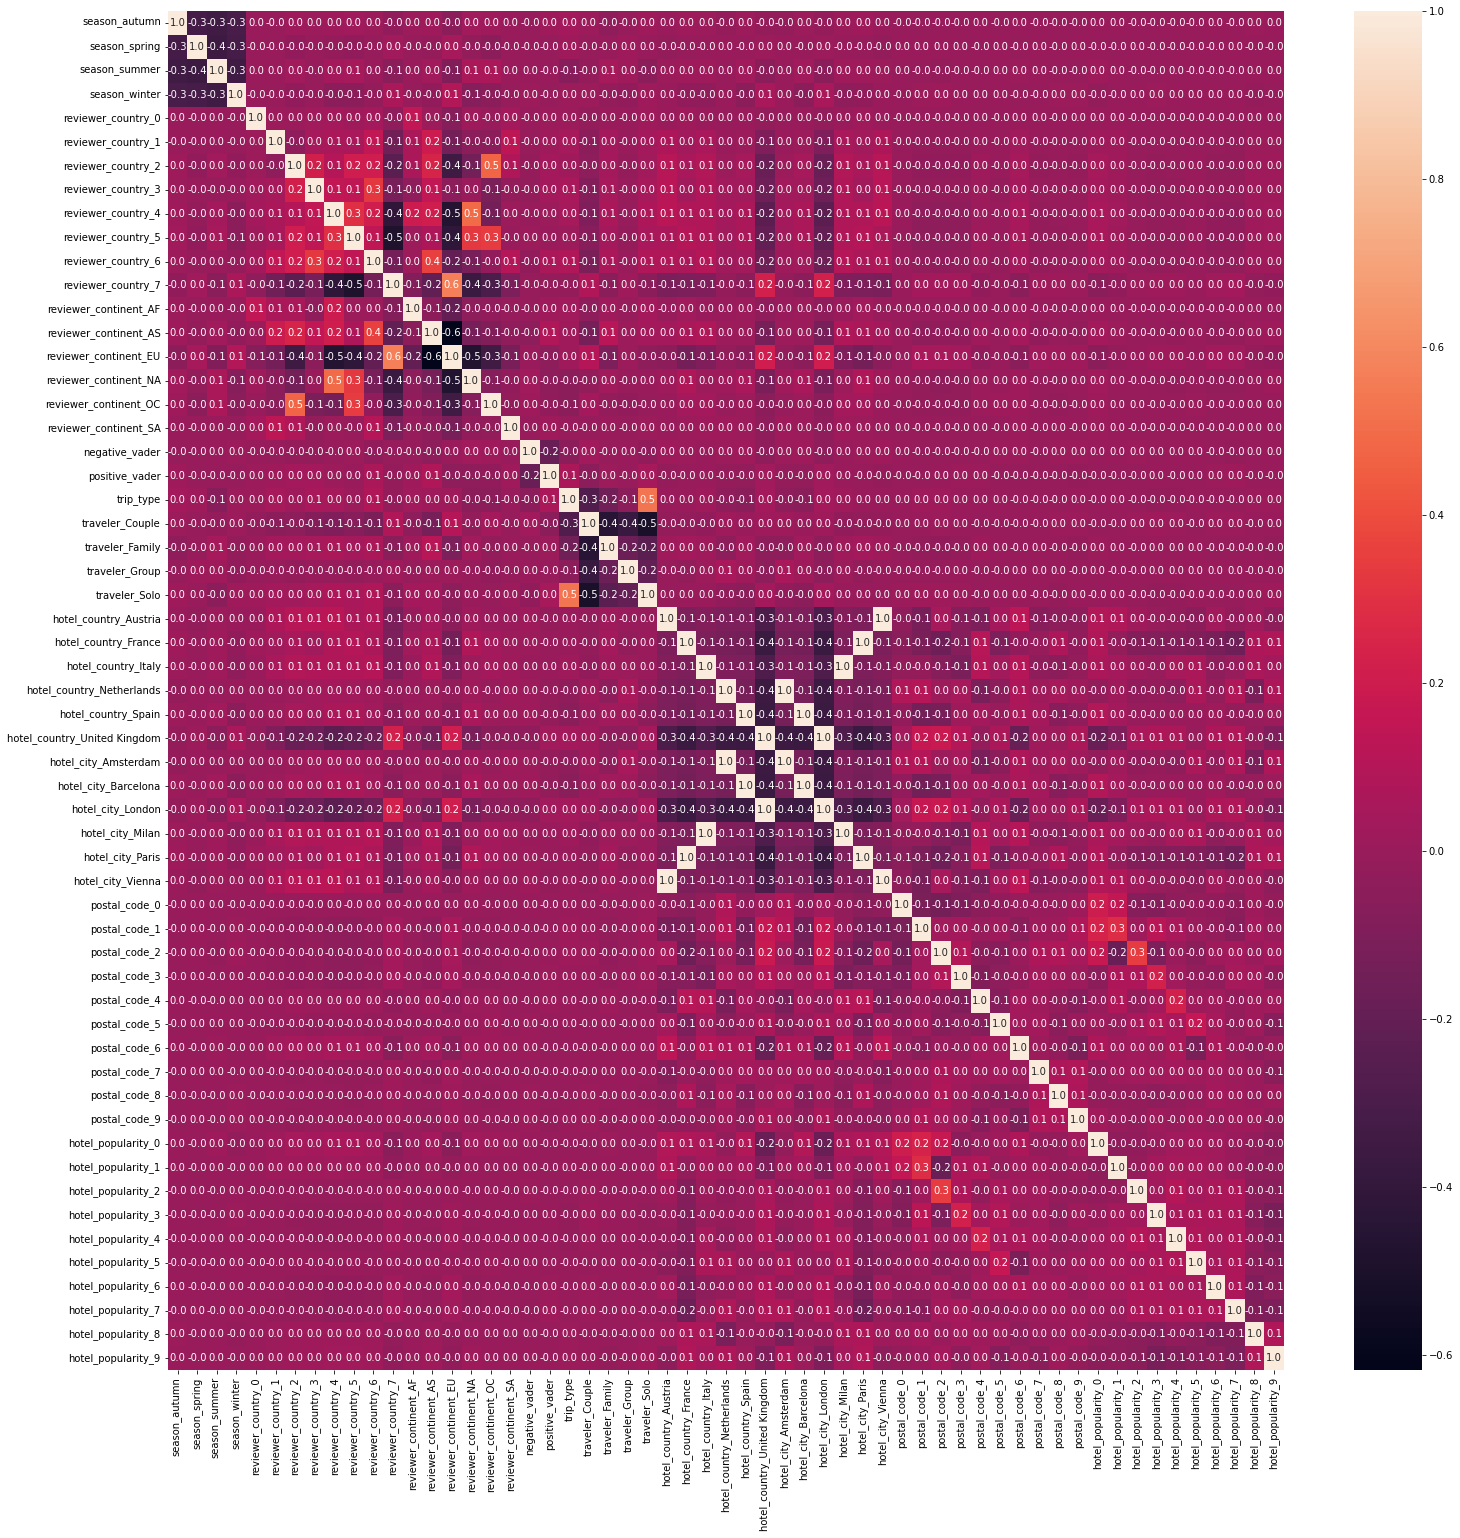

In [15]:
# Correlation Spearman for categorical data

fig = plt.figure(figsize=(25, 25))
sns.heatmap(hotels[cat_cols].corr(method = 'spearman'), annot = True, fmt=".1f");

experiment.log_figure(figure = plt)

In [16]:
#Deleting unnecessary features

hotels.drop([
    # new features has been created out of data in these columns
    'hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review','positive_review', 'tags', 
    'days_since_review', 'negative_review_score','positive_review_score', 'review_date',
    
    # new features has been created due to encoding
    'hotel_popularity', 'postal_code', 'reviewer_country', 'nights',
    
    # multicorrelation test results
    'neu_negative_review_score'], axis = 1, inplace = True)

# ANOVA test for Numerical Features

(386803, 77)
(386803,)


{'web': 'https://www.comet.com/api/image/download?imageId=c4974746f7524133954b864daccf8db9&experimentKey=b9f05268a0034f5aa32e5d07d23df466',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=c4974746f7524133954b864daccf8db9&experimentKey=b9f05268a0034f5aa32e5d07d23df466',
 'imageId': 'c4974746f7524133954b864daccf8db9'}

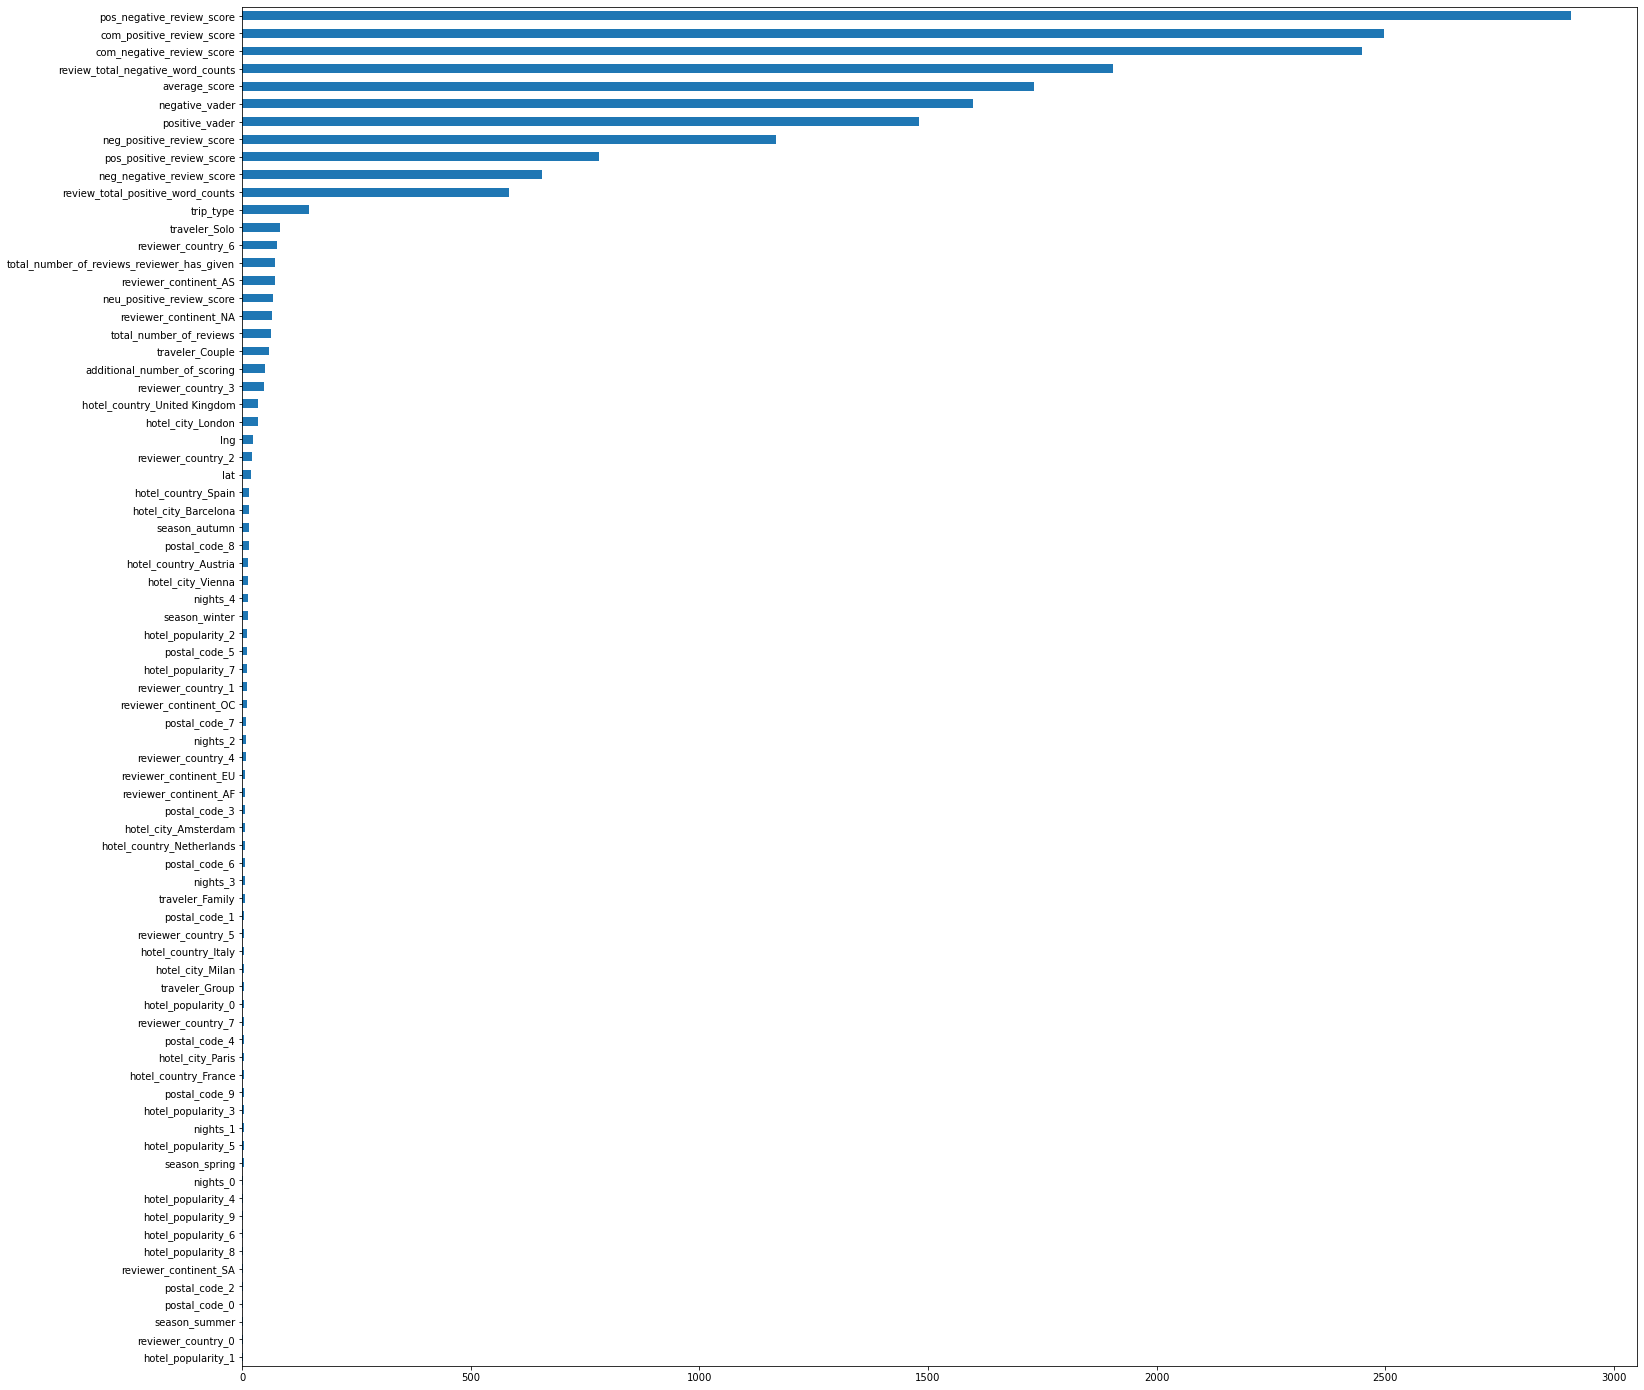

In [17]:
from sklearn.feature_selection import f_classif # anova

X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

print(X.shape)
print(y.shape)

#imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
#imp_num.sort_values(inplace = True)

imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig = plt.figure(figsize=(25, 25))
imp_num.plot(kind = 'barh');

experiment.log_figure(figure = plt)

In [18]:
#Deleting unnecessary features

hotels.drop([
    # ANOVA test results
    'nights_0', 'nights_1', 'nights_2', 'nights_3', 'nights_4',
    
    'hotel_popularity_0', 'hotel_popularity_1', 'hotel_popularity_2', 'hotel_popularity_3', 'hotel_popularity_4',
    'hotel_popularity_5', 'hotel_popularity_6', 'hotel_popularity_7', 'hotel_popularity_8', 'hotel_popularity_9',
    
    'postal_code_0', 'postal_code_1', 'postal_code_2', 'postal_code_3', 'postal_code_4', 'postal_code_5',
    'postal_code_6', 'postal_code_7', 'postal_code_8', 'postal_code_9', 
   
    'negative_vader', 'positive_vader'], axis = 1, inplace = True)

In [19]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   lat                                         386803 non-null  float64
 8   lng                                         386803 non-null  float64
 9   neg_negative_review_score                   386803 non-null  float64
 

# Model

In [20]:
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 


print(X.shape)
print(y.shape)

(386803, 50)
(386803,)


In [21]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestRegressor   
from sklearn import metrics 

regr = RandomForestRegressor(n_estimators=100)  

In [23]:
regr.fit(X_train, y_train)

RandomForestRegressor()

In [24]:
params={"model_type":"regr"}

In [25]:
experiment.log_parameters(params)

In [26]:
y_pred = regr.predict(X_test)  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12349086039192124


In [28]:
metrics = {"MAPE":metrics.mean_absolute_percentage_error(y_test, y_pred)}

In [29]:
experiment.log_metrics(metrics)

In [30]:
experiment.display()

In [31]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nataliamantyk/booking-com-hotels-ratings/b9f05268a0034f5aa32e5d07d23df466
COMET INFO:   Metrics:
COMET INFO:     MAPE : 0.12349086039192124
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     criterion                : mse
COMET INFO:     max_depth                : 1
COMET INFO:     max_features             : auto
COMET INFO:     max_leaf_nodes           : 1
COMET INFO:     max_samples              : 1
COMET INFO:     min_impurity_decrease    : 0.0
COMET INFO:     min_impurity_split       : 1
COMET INFO:     min_samples_leaf         : 1
COMET INFO:     min_samples_split        : 2
COMET INFO:     min_weight_fraction_leaf : 0.0
COMET INFO:     model_type          